https://pygis.io/docs/d_access_census.html

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states

In [2]:
# Set API key
c = Census("[redacted]")

In [3]:
# Obtain Census variables from the 2019 ACS at the tract level for the Commonwealth of Virginia (FIPS code: 51)
# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population
# Sources: https://api.census.gov/data/2019/acs/acs5/variables.html; https://pypi.org/project/census/
va_census = c.acs5.state_county_tract(fields = ('NAME', 'C17002_001E', 'C17002_002E', 'C17002_003E', 'B01003_001E'),
                                      state_fips = states.VA.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2017)

In [4]:
# Create a dataframe from the census data
va_df = pd.DataFrame(va_census)

# Show the dataframe
print(va_df.head(2))
print('Shape: ', va_df.shape)

                                         NAME  C17002_001E  C17002_002E  \
0     Census Tract 60, Norfolk city, Virginia       3947.0        284.0   
1  Census Tract 65.02, Norfolk city, Virginia       3287.0        383.0   

   C17002_003E  B01003_001E state county   tract  
0        507.0       3947.0    51    710  006000  
1        480.0       3302.0    51    710  006502  
Shape:  (1907, 8)


In [5]:
# Access shapefile of Virginia census tracts
va_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_51_tract.zip")

# Reproject shapefile to UTM Zone 17N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-17n/
# va_tract = va_tract.to_crs(epsg = 32617)
va_tract = va_tract.to_crs(epsg = 3857)

# Print GeoDataFrame of shapefile
print(va_tract.head(2))
print('Shape: ', va_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(va_tract.crs))

  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2552457       0  +37.1475176  -076.5212499   
1        S  3478916  165945  +37.1625163  -076.5527816   

                                            geometry  
0  POLYGON ((-8519184.450 4458798.883, -8519182.3...  
1  POLYGON ((-8523603.723 4463501.697, -8523507.4...  
Shape:  (1907, 13)

The shapefile projection is: EPSG:3857


In [6]:
va_tract.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
# Combine state, county, and tract columns together to create a new string and assign to new column
va_df["GEOID"] = va_df["state"] + va_df["county"] + va_df["tract"]

In [8]:
# Print head of dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,state,county,tract,GEOID
0,"Census Tract 60, Norfolk city, Virginia",3947.0,284.0,507.0,3947.0,51,710,006000,51710006000
1,"Census Tract 65.02, Norfolk city, Virginia",3287.0,383.0,480.0,3302.0,51,710,006502,51710006502


In [9]:
# Remove columns
va_df = va_df.drop(columns = ["state", "county", "tract"])

# Show updated dataframe
va_df.head(2)

,NAME,C17002_001E,C17002_002E,C17002_003E,B01003_001E,GEOID
0,"Census Tract 60, Norfolk city, Virginia",3947.0,284.0,507.0,3947.0,51710006000
1,"Census Tract 65.02, Norfolk city, Virginia",3287.0,383.0,480.0,3302.0,51710006502


In [10]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(va_df.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(va_tract.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
C17002_001E    float64
C17002_002E    float64
C17002_003E    float64
B01003_001E    float64
GEOID           object
dtype: object

Column data types for census shapefile:
STATEFP       object
COUNTYFP      object
TRACTCE       object
GEOID         object
NAME          object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object


In [11]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
va_merge = va_tract.merge(va_df, on = "GEOID")

# Show result
print(va_merge.head(2))
print('Shape: ', va_merge.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  NAME_x             NAMELSAD  MTFCC  \
0      51      700  032132  51700032132  321.32  Census Tract 321.32  G5020   
1      51      700  032226  51700032226  322.26  Census Tract 322.26  G5020   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S  2552457       0  +37.1475176  -076.5212499   
1        S  3478916  165945  +37.1625163  -076.5527816   

                                            geometry  \
0  POLYGON ((-8519184.450 4458798.883, -8519182.3...   
1  POLYGON ((-8523603.723 4463501.697, -8523507.4...   

                                             NAME_y  C17002_001E  C17002_002E  \
0  Census Tract 321.32, Newport News city, Virginia       5025.0        161.0   
1  Census Tract 322.26, Newport News city, Virginia       4167.0        736.0   

   C17002_003E  B01003_001E  
0        342.0       5079.0  
1        559.0       4167.0  
Shape:  (1907, 18)


In [12]:
# Create new dataframe from select columns
va_poverty_tract = va_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", "C17002_001E", "C17002_002E", "C17002_003E", "B01003_001E"]]

# Show dataframe
print(va_poverty_tract.head(2))
print('Shape: ', va_poverty_tract.shape)

  STATEFP COUNTYFP TRACTCE        GEOID  \
0      51      700  032132  51700032132   
1      51      700  032226  51700032226   

                                            geometry  C17002_001E  \
0  POLYGON ((-8519184.450 4458798.883, -8519182.3...       5025.0   
1  POLYGON ((-8523603.723 4463501.697, -8523507.4...       4167.0   

   C17002_002E  C17002_003E  B01003_001E  
0        161.0        342.0       5079.0  
1        736.0        559.0       4167.0  
Shape:  (1907, 9)


In [13]:
# Dissolve and group the census tracts within each county and aggregate all the values together
# Source: https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html
va_poverty_county = va_poverty_tract.dissolve(by = 'COUNTYFP', aggfunc = 'sum')

# Show dataframe
print(va_poverty_county.head(2))
print('Shape: ', va_poverty_county.shape)

  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


                                                   geometry  C17002_001E  \
COUNTYFP                                                                   
001       POLYGON ((-8423152.131 4504489.394, -8423339.5...      32345.0   
003       POLYGON ((-8734994.983 4554504.865, -8735070.9...      97587.0   

          C17002_002E  C17002_003E  B01003_001E  
COUNTYFP                                         
001            2423.0       3993.0      32840.0  
003            5276.0       4305.0     105105.0  
Shape:  (133, 5)


In [14]:
# Get poverty rate and store values in new column
va_poverty_county["Poverty_Rate"] = (va_poverty_county["C17002_002E"] + va_poverty_county["C17002_003E"]) / va_poverty_county["B01003_001E"] * 100

# Show dataframe
va_poverty_county.head(2)

,geometry,C17002_001E,C17002_002E,C17002_003E,B01003_001E,Poverty_Rate
COUNTYFP,,,,,,
001,"POLYGON ((-8423152.131 4504489.394, -8423339.5...",32345.0,2423.0,3993.0,32840.0,19.537150
003,"POLYGON ((-8734994.983 4554504.865, -8735070.9...",97587.0,5276.0,4305.0,105105.0,9.115646


Text(0.5, 1.0, 'Poverty Rates (%) in Virginia')

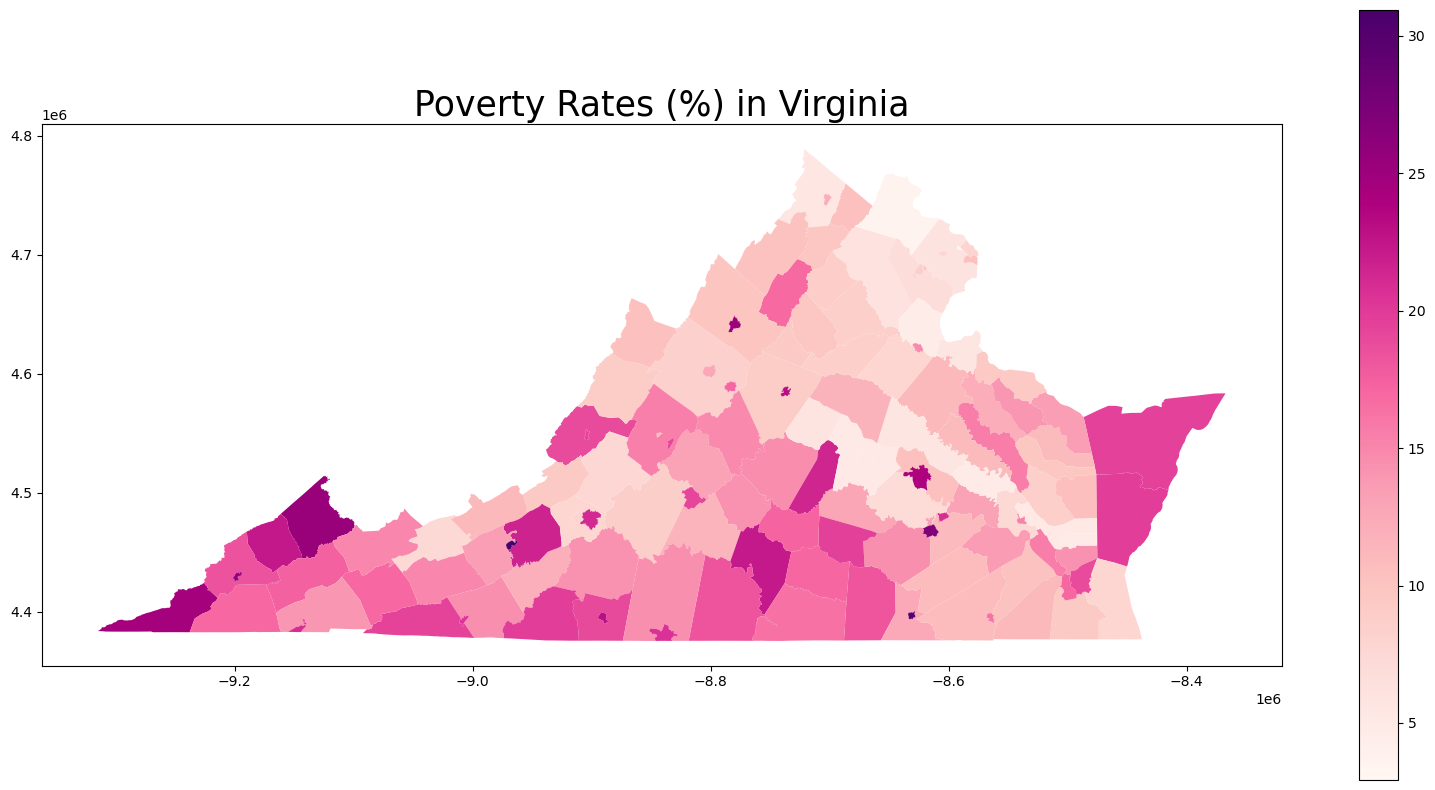

In [15]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
va_poverty_county.plot(column = "Poverty_Rate",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Poverty Rates (%) in Virginia', fontdict = {'fontsize': '25', 'fontweight' : '3'})
